In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(16,8)})

In [86]:
df_esb = pd.read_csv('../data/2020_05_04/esb.csv').drop('serviceName', axis=1)
df_esb['startTime'] = pd.to_datetime(df_esb['startTime'], unit='ms')
# df_esb.set_index('startTime')

In [87]:
df_esb.head()

,startTime,avg_time,num,succee_num,succee_rate
0,2020-05-03 16:00:00,0.5691,347,347,1.0
1,2020-05-03 16:01:00,0.5813,354,354,1.0
2,2020-05-03 16:02:00,0.5397,363,363,1.0
3,2020-05-03 16:03:00,0.6190,387,387,1.0
4,2020-05-03 16:04:00,0.4909,387,387,1.0


In [88]:
df_esb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439 entries, 0 to 1438
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   startTime    1439 non-null   datetime64[ns]
 1   avg_time     1439 non-null   float64       
 2   num          1439 non-null   int64         
 3   succee_num   1439 non-null   int64         
 4   succee_rate  1439 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 56.3 KB


In [89]:
#RIP successes
df_esb.describe()

,avg_time,num,succee_num,succee_rate
count,1439.000000,1439.000000,1439.000000,1439.0
mean,0.606253,507.325226,507.325226,1.0
std,0.042155,72.569547,72.569547,0.0
min,0.490900,303.000000,303.000000,1.0
25%,0.580900,449.000000,449.000000,1.0
50%,0.604100,510.000000,510.000000,1.0
75%,0.631300,565.000000,565.000000,1.0
max,0.923700,704.000000,704.000000,1.0


<AxesSubplot:xlabel='startTime', ylabel='num'>

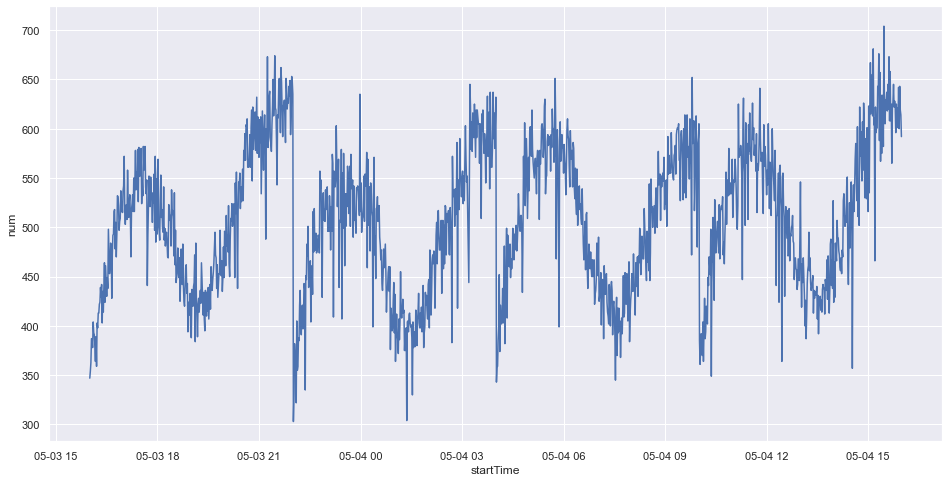

In [90]:
sns.lineplot(x='startTime', y='num', data=df_esb)

<AxesSubplot:xlabel='startTime', ylabel='avg_time'>

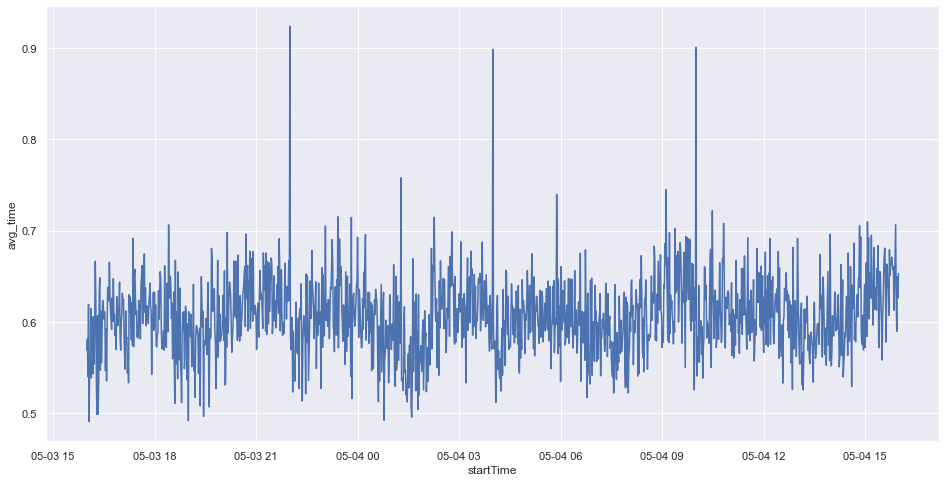

In [91]:
sns.lineplot(x='startTime', y='avg_time', data=df_esb)

In [92]:
def complete_timestamp(timestamp, arrays=None):
    """
    Complete `timestamp` such that the time interval is homogeneous.
    Zeros will be inserted into each array in `arrays`, at missing points.
    Also, an indicator array will be returned to indicate whether each
    point is missing or not.
    Args:
        timestamp (np.ndarray): 1-D int64 array, the timestamp values.
            It can be unsorted.
        arrays (Iterable[np.ndarray]): The 1-D arrays to be filled with zeros
            according to `timestamp`.
    Returns:
        np.ndarray: A 1-D int64 array, the completed timestamp.
        np.ndarray: A 1-D int32 array, indicating whether each point is missing.
        list[np.ndarray]: The arrays, missing points filled with zeros.
            (optional, return only if `arrays` is specified)
    """
    timestamp = np.asarray(timestamp, np.int64)
    if len(timestamp.shape) != 1:
        raise ValueError('`timestamp` must be a 1-D array')

    has_arrays = arrays is not None
    arrays = [np.asarray(array) for array in (arrays or ())]
    for i, array in enumerate(arrays):
        if array.shape != timestamp.shape:
            raise ValueError('The shape of ``arrays[{}]`` does not agree with '
                             'the shape of `timestamp` ({} vs {})'.
                             format(i, array.shape, timestamp.shape))

    # sort the timestamp, and check the intervals
    src_index = np.argsort(timestamp)
    timestamp_sorted = timestamp[src_index]
    intervals = np.unique(np.diff(timestamp_sorted))
    interval = np.min(intervals)
    if interval == 0:
        raise ValueError('Duplicated values in `timestamp`')
    for itv in intervals:
        if itv % interval != 0:
            raise ValueError('Not all intervals in `timestamp` are multiples '
                             'of the minimum interval')

    # prepare for the return arrays
    length = (timestamp_sorted[-1] - timestamp_sorted[0]) // interval + 1
    ret_timestamp = np.arange(timestamp_sorted[0],
                              timestamp_sorted[-1] + interval,
                              interval,
                              dtype=np.int64)
    ret_missing = np.ones([length], dtype=np.int32)
    ret_arrays = [np.zeros([length], dtype=array.dtype) for array in arrays]

    # copy values to the return arrays
    dst_index = np.asarray((timestamp_sorted - timestamp_sorted[0]) // interval,
                           dtype=np.int)
    ret_missing[dst_index] = 0
    for ret_array, array in zip(ret_arrays, arrays):
        ret_array[dst_index] = array[src_index]

    if has_arrays:
        return ret_timestamp, ret_missing, ret_arrays
    else:
        return ret_timestamp, ret_missing


def standardize_kpi(values, mean=None, std=None, excludes=None):
    """
    Standardize a
    Args:
        values (np.ndarray): 1-D `float32` array, the KPI observations.
        mean (float): If not :obj:`None`, will use this `mean` to standardize
            `values`. If :obj:`None`, `mean` will be computed from `values`.
            Note `mean` and `std` must be both :obj:`None` or not :obj:`None`.
            (default :obj:`None`)
        std (float): If not :obj:`None`, will use this `std` to standardize
            `values`. If :obj:`None`, `std` will be computed from `values`.
            Note `mean` and `std` must be both :obj:`None` or not :obj:`None`.
            (default :obj:`None`)
        excludes (np.ndarray): Optional, 1-D `int32` or `bool` array, the
            indicators of whether each point should be excluded for computing
            `mean` and `std`. Ignored if `mean` and `std` are not :obj:`None`.
            (default :obj:`None`)
    Returns:
        np.ndarray: The standardized `values`.
        float: The computed `mean` or the given `mean`.
        float: The computed `std` or the given `std`.
    """
    values = np.asarray(values, dtype=np.float32)
    if len(values.shape) != 1:
        raise ValueError('`values` must be a 1-D array')
    if (mean is None) != (std is None):
        raise ValueError('`mean` and `std` must be both None or not None')
    if excludes is not None:
        excludes = np.asarray(excludes, dtype=np.bool)
        if excludes.shape != values.shape:
            raise ValueError('The shape of `excludes` does not agree with '
                             'the shape of `values` ({} vs {})'.
                             format(excludes.shape, values.shape))

    if mean is None:
        if excludes is not None:
            val = values[np.logical_not(excludes)]
        else:
            val = values
        mean = val.mean()
        std = val.std()

    return (values - mean) / std, mean, std


def standardize_kpi_df(df, column_name, new_column=None):
    if(new_column is None):
        new_column = column_name 
        
    df[new_column] = (df[column_name] - df[column_name].mean())
    return df

# def differenciate_df(df, periods=1, freq='1M'):
    

In [93]:
#df_esb['avg_time_st'] = (df_esb['avg_time'] - df_esb['avg_time'].mean()) #/ df_esb['avg_time'].std()

df_esb = standardize_kpi_df(df_esb, column_name='avg_time', new_column='avg_time_st')
df_esb = standardize_kpi_df(df_esb, column_name='num', new_column='num_st')

In [94]:
df_esb_10 = df_esb.set_index(['startTime']).resample('10Min')
df_esb_60 = df_esb.set_index(['startTime']).resample('60Min')

# df_esb_diff = df_esb.pct_change()

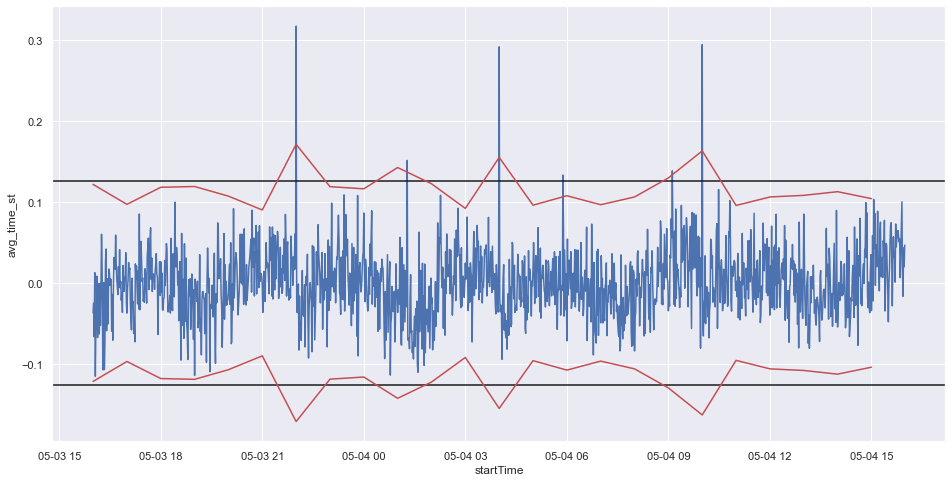

In [101]:
sns.lineplot(x='startTime', y='avg_time_st', data=df_esb)

fixed_threshold = 3 * df_esb['avg_time'].std()
plt.axhline(fixed_threshold, color='k')
plt.axhline(-fixed_threshold, color='k')

rolling_threshold = 3 * df_esb_60['avg_time'].std()
plt.plot(rolling_threshold, color='r')
plt.plot(-rolling_threshold, color='r')

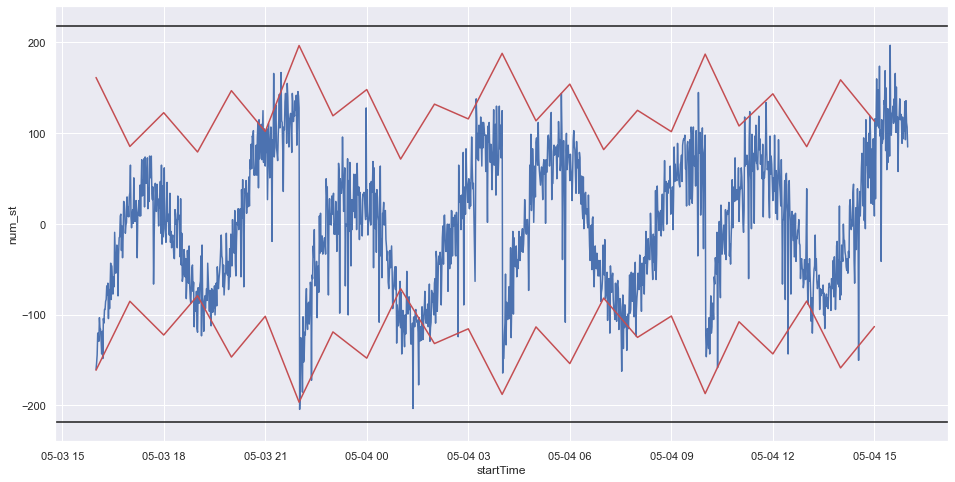

In [102]:
sns.lineplot(x='startTime', y='num_st', data=df_esb)

fixed_threshold = 3 * df_esb['num'].std()
plt.axhline(fixed_threshold, color='k')
plt.axhline(-fixed_threshold, color='k')

rolling_threshold = 3 * df_esb_60['num'].std()
plt.plot(rolling_threshold, color='r')
plt.plot(-rolling_threshold, color='r')